**Test with Iris dataset and Test and train split function**

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train[0])
print(y_test[0])


(120, 4)
(30, 4)
(120,)
(30,)
[6.1 3.  4.6 1.4]
0


### Architecture definition

In [3]:
#define ANN architecture as a Torch NN Module

import torch.nn as nn

class ANN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.lin1 = nn.Linear(4, 10)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 20)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(20, num_classes)
        
    def forward(self, x, debug=False):
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.lin1(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.act1(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.lin2(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.act2(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        y = self.lin3(x)
        if debug : print(f'Shape de entrada: {y.shape}')
        return y         

In [3]:
import torch

print(torch.cuda.is_available())

True


### Model analysis

In [ ]:
import torch

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

net = ANN( num_classes=3 )
#net = ANN()

net = net.to(my_device)

a = torch.rand( (1, 4) )
a = a.to(my_device)
b = net( a , debug=True)

del a, b, net

Running on cuda.
Shape de entrada: torch.Size([1, 4])
Shape de entrada: torch.Size([1, 10])
Shape de entrada: torch.Size([1, 10])
Shape de entrada: torch.Size([1, 20])
Shape de entrada: torch.Size([1, 20])
Shape de entrada: torch.Size([1, 3])


In [ ]:
from torchsummary import summary

net = ANN( num_classes=3 )

net = net.to(my_device)

summary(net, input_size=(1, 4), batch_size=1)

del net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 10]              50
              ReLU-2                 [1, 1, 10]               0
            Linear-3                 [1, 1, 20]             220
              ReLU-4                 [1, 1, 20]               0
            Linear-5                  [1, 1, 3]              63
Total params: 333
Trainable params: 333
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Training functions

In [ ]:
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

def train ( dataset, prefix=None, upper_bound=101.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=True, lambda_reg=0 ) :
    
    num_classes = 3
    
    tensorboard_path = '/homeLocal/praticas-cv-cnn/Tensorboard/practice2/2025-1/'
  
    net = ANN( num_classes )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    accuracies = []
    max_accuracy = -1.0  
    
    data_loader = train_test_split( dataset.data,
                                     dataset.target,
                                     test_size=0.2,
                                     random_state=1 )
    
    train_x,test_x,train_label,test_label = data_loader
    
    train_x = torch.from_numpy(train_x).float()
    train_x = train_x.to(device)
    train_label = torch.from_numpy(train_label).float()
    train_label = train_label.to(device)
    
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x.to(device)
    test_label = torch.from_numpy(test_label).float()
    test_label = test_label.to(device)
    
    writer.add_graph(net, train_x)
    
    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        
        # Set Pytorch variables
        net.train()
        optimizer.zero_grad()
                            
        # Forward step
        predict_y = net( train_x )
        
        # Loss
        error = criterion( predict_y , train_label.long() )

        # Back propagation
        error.backward()
        optimizer.step()

        # Accuracies:
        predict_ys = torch.max( predict_y, axis=1 )[1]
        correct    = torch.sum( predict_ys == train_label )
        accuracy_train = correct/train_x.size(0)
        
        accuracy_test = validate(net, test_x, test_label, device=device)
        accuracies.append(accuracy_test)
        
        # Tensor board writing
        writer.add_scalar( 'Loss/train', error.item(), epoch )
        writer.add_scalar( 'Accuracy/train', accuracy_train, epoch )
        writer.add_scalar( 'Accuracy/test', accuracy_test, epoch )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        # Test model
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy_test
            print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                    f'with Accuracy: {accuracy_test:8.4f}%')
      
        if debug : print( f'Epoch: {epoch+1:3d} |' 
                         + f'Accuracy Test: {accuracy_test:3.4f}%' )

        if accuracy_test > upper_bound :
            break
   
    if save : 
        models_path = '/homeLocal/praticas-cv-cnn/models/'
        path = f'{models_path}{prefix}-{max_accuracy:.2f}.pkl'
        torch.save( best_model, path )
        print( f'Model saved in: {path}' )
  
    plt.figure(figsize=(16, 8))
    plt.plot(accuracies)

    writer.flush()
    writer.close()

    return best_model

In [ ]:
def validate ( model , test_x, test_label , device='cpu') :

    model.eval()

    predict_y = model( test_x ).detach()
    predict_ys = torch.max( predict_y, axis=1 )[1]
    correct = torch.sum(predict_ys == test_label)
  
    return correct.to('cpu').numpy()*100./test_x.size(0)

In [ ]:
def plot_layers ( net , writer, epoch ) :
    layers = list(net.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

### Run the training phase

Running on cuda


Training epochs...:   1%|▏                      | 5/500 [00:00<00:11, 43.06it/s]

Saving the best model at epoch   1 with Accuracy:  20.0000%
Saving the best model at epoch   7 with Accuracy:  33.3333%
Saving the best model at epoch   8 with Accuracy:  46.6667%
Saving the best model at epoch   9 with Accuracy:  53.3333%


Training epochs...:   2%|▍                     | 10/500 [00:00<00:12, 40.03it/s]

Saving the best model at epoch  10 with Accuracy:  56.6667%


Training epochs...:   5%|█                     | 25/500 [00:00<00:11, 41.09it/s]

Saving the best model at epoch  21 with Accuracy:  60.0000%
Saving the best model at epoch  27 with Accuracy:  73.3333%
Saving the best model at epoch  29 with Accuracy:  76.6667%


Training epochs...:   7%|█▌                    | 35/500 [00:00<00:11, 40.99it/s]

Saving the best model at epoch  31 with Accuracy:  86.6667%
Saving the best model at epoch  33 with Accuracy:  96.6667%


Training epochs...:  34%|███████              | 168/500 [00:04<00:08, 37.07it/s]

Saving the best model at epoch 163 with Accuracy: 100.0000%


Training epochs...: 100%|█████████████████████| 500/500 [00:13<00:00, 38.11it/s]


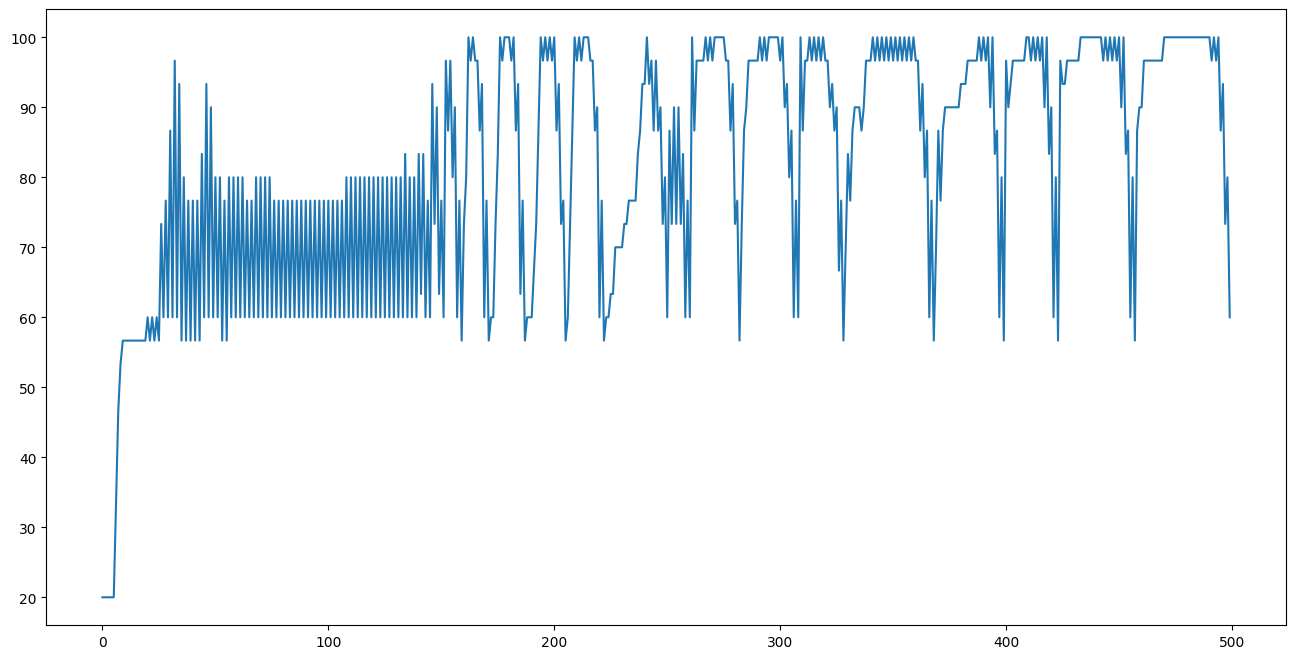

In [ ]:
from sklearn.datasets import load_iris

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
    
print(f"Running on {my_device.type}")
    
dataset = 'Iris'
epochs = 500
lr = 1e-1
lambda_reg = 1e-4
prefix = 'ANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

iris = load_iris()
dataset = iris

net = train( dataset=dataset, epochs=epochs, device=my_device, 
            upper_bound=101.0, lr=lr, lambda_reg=lambda_reg,
            layers2tensorboard=True, save=False, prefix=prefix
           )

In [ ]:
print(net)

import numpy as np

test_x = torch.from_numpy(X_test).float()
test_x = test_x.to(my_device)
test_label = torch.from_numpy(y_test).float()
test_label = test_label.to(my_device)

indice  = np.random.randint(0,30)

print(test_x[indice])
output = net(test_x[indice])
print(output)
predictedd_class = torch.max(output, dim=0)[1]

print(f'saida do modelo: {predictedd_class.to('cpu').numpy()} e saída correta {y_test[indice]} para o indice {indice}')

ANN(
  (lin1): Linear(in_features=4, out_features=10, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=10, out_features=20, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=20, out_features=3, bias=True)
)
tensor([5.7000, 2.8000, 4.1000, 1.3000], device='cuda:0')
tensor([-2.1578,  2.1892,  0.6821], device='cuda:0', grad_fn=<ViewBackward0>)
saida do modelo: 1 e saída correta 1 para o indice 25
